In [86]:
import pandas as pd
import holoviews as hv
import numpy as np
import scanpy as sc
from holoviews import opts, dim

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import dendrogram
import fastcluster

In [87]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

/tmp/ipykernel_3808264/3954553629.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


In [88]:
pred = pd.read_parquet('Tangram_CombinedNamesMerge.parquet')
obs =  pd.read_csv('../Figure1_and_Supp/Tangram_CombinedNamesMerge_obs.parquet')
nodes_annotation = pred.columns.values
nodes_gc = obs.CombinedNameMerge.unique()

nodes_list = nodes_annotation.tolist() + nodes_gc.tolist()

cutoff = 0
#pred2 = [(i[0], i[1].sum(axis=0)/i[1].sum(axis=0).sum()*100) for i in pred.groupby('MolecularNgh')]
pred2 = []
for m, group in pred.groupby('CombinedNameMerge'):

    #print(m,group)
    group_n = group #* obs.ncells[obs.MolecularNgh == m].values[:,None]
    group_n = group_n.sum(axis=0)
    #print(group_n)
    #break
    percentage = group_n / group_n.sum()*100
    pred2.append((m,percentage))
#pred2 = [(p[0], p[1][p[1] >=cutoff]  )  for p in pred2]
#pred2 = [(p[0], p[1]/p[1].sum()*(100/obs.MolecularNgh.unique().shape[0])  )  for p in pred2]

edges = []
values = []
for gc, p in pred2:
    for i, val in zip(p.index,p.values):
        #if val >= cutoff:
        #edges.append((nodes_list.index(gc), nodes_list.index(i),val*1))
        edges.append((gc, i,val*1))

pred2 = pd.DataFrame(data=np.zeros([nodes_gc.shape[0],nodes_annotation.shape[0]]),index= nodes_gc, columns=nodes_annotation)
for i,c,v in edges:
    try:
        pred2.loc[i][c] = v
    except:
        pass
#pred2 = pred2/pred2.sum(axis=1)[:,None]*100

In [89]:

cluster_colors_GBM = {
    'AC-like':'#2ecc71',#inchworm B4FF9F
    'GBL-like':'#c2f970',#'#c2f970'
    'preOPC-like':'#7befb2',#'#c2f970'
    'AC-like Prolif':'#c2f970',
    'MES-like hypoxia independent':'#e76d89',# Deep cerise
    'MES-like hypoxia/MHC':'#e76d89',# Deep cerise
    'MES-like': '#e76d89',# Deep cerise
    'NPC-like':'#FFF192', 
    'RG':'#ff9470', #'#fbc093',  #melon melody
    
    'OPC-like':'#89c4f4', #bright turquoise
    
    'Astrocyte':'#26c281', #jungles greeen
    'OPC':'#bfbfbf', #silver,#mystic
    'Neuron':'#ffff9f',# canary
    'Oligodendrocyte':'#392e4a',#martynique
    
    'B cell':'#eefcf5',#white 
    'Plasma B':'#4871f7', #cornflower blue
    'CD4/CD8':'#a2ded0', #aqua island
    'DC':'#848ccf', #atomic tangerine 
    'Mast':'#825e5c', #ligh wood
    'Mono':'#f4ede4', #alabaster
    'TAM-BDM':'#e3ba8f', #wood
    'TAM-MG':'#a6915c',#red orange
    'NK':'#bedce3', #ziggurat
    
    'Endothelial':'#d5b8ff', #mauve
    'Mural cell': '#8c14fc',  #electric indigo
    'Mural': '#8c14fc',  #electric indigo
    'Fibroblast': '#fbe7ef',
    'FBL-like': '#FF6EC7' #fff9de
}


In [90]:
reference_means = sc.read_h5ad('../reference_celltypes/GBM_annotation_level3.h5ad')

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [91]:
select = ['AC-like', 'NPC-like', 'OPC-like', 'MES-like', 'Mural cell', 'Endothelial']
predictions = df.columns[df.values.argsort(axis=1)[:,-1]]
development_bonefight = df.index[predictions.isin(select)]

In [93]:

df = pd.DataFrame(data=pred2.values,index=pred2.index.values,columns=pred2.columns)

# Ordering scRNAseq
metric='euclidean'
method = 'ward'

#df_means= pd.DataFrame(data=reference_means.X,index=reference_means.obs.annotation )

D = pdist(df.values.T, metric)
#D = pdist(df.values, metric)
Z = fastcluster.linkage(D, method=method,metric=metric, preserve_input=True)
Z = hc.optimal_leaf_ordering(Z, D, metric=metric)
ordering_sc = hc.leaves_list(Z)
#ordering_sc_str = df.columns[ordering_sc]
ordering_sc_str = df.columns[ordering_sc][::-1]

# Ordering EEL
D = pdist(df.values, metric)
Z = fastcluster.linkage(D, method=method, metric=metric,preserve_input=True)
Z = hc.optimal_leaf_ordering(Z, D, metric=metric)
ordering_sp = hc.leaves_list(Z)
ordering_sp_str = df.index.values[ordering_sp][::-1]

remove = ['27']
ordering_dotplot = np.array(['76', '2', '54', '48', '4', '25', '64', '11', '44', '36', '73',
       '63', '59', '38', '77', '79', '52', '56', '45', '14', '74', '16',
       '24', '10', '71', '67', '53', '34', '72', '29', '20', '12', '7',
       '37', '3', '18', '8', '31', '66', '26', '70', '1', '41', '22',
       '60', '61', '15', '57', '33', '58', '46', '62', '28', '5', '30',
       '21', '19', '23', '47', '43', '75', '68', '0', '49', '42', '78',
       '65', '40', '69', '55', '17', '13', '35'])

#ordering_dotplot = ordering_dotplot[np.isin(ordering_dotplot, remove, invert=True)]

#ordering_sc_str = ['AC-like','MES-like','OPC-like','NPC-like','RG', 'Mural cell', 'Endothelial','Plasma B','NK','CD4/CD8','DC', 'TAM-MG', 'TAM-BDM', 'Mono', 'Oligodendrocyte']
ordering_sc_custom = ['AC-like', 'OPC-like','NPC-like', 'MES-like','Mono','DC','CD4/CD8', 'Plasma B', 'NK', 'TAM-BDM', 'TAM-MG', 'Oligodendrocyte', 'Mural cell','Endothelial']
df = df.loc[:,ordering_sc_custom]

'''heat_map(df, 
    df.columns,sort=ordering_sc_str.values,
    cluster_colors=cluster_colors_GBM
)'''

'heat_map(df, \n    df.columns,sort=ordering_sc_str.values,\n    cluster_colors=cluster_colors_GBM\n)'

In [97]:
ordering_sp_custom = [
    'AC-like 1', 'AC-like 2', 'AC-like 3', 'AC-like 4', 'AC-like 5', 'AC-like 6', 'AC-like 7',
    'GBL-like 1', 'GBL-like 2',
    'preOPC-like 1', 
    'OPC-like 1', 'OPC-like 2',
    'RG 1', 'RG 2',
    'NPC-like 1', 'NPC-like 2' , 'NPC-like 3',
    'FB-like 1', 'FB-like 2', 'FB-like 3',
    'MES-like 1', 'MES-like 2', 'MES-like 3', 'MES-like 4', 'MES-like 5', 'MES-like 6', 'MES-like 7', 'MES-like 8',
    'Mono 1', 'Mono 2',
    'TAM-MG', 'TAM-BDM 4', 'TAM-BDM 3', 'TAM-BDM 1', 'TAM-BDM 2',
    'DC',
    'Oligodendrocyte 1',
    'Oligodendrocyte 2',
    'Erythrocyte 1',
    'Mural cell 1','Mural cell 2',
    'Endothelial 1'
    
                    ]
print(len(ordering_sp_custom))

ordering_sp_str = ordering_sp_str[np.isin(ordering_sp_str, [9,51],invert=True)]
df = df.loc[ordering_sp_custom]


42


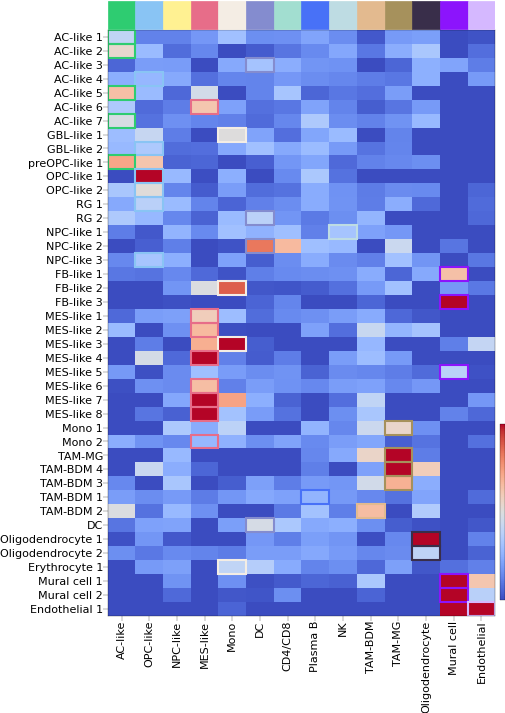

In [98]:
import matplotlib.pyplot as plt
from collections import Counter
from mpl_toolkits.axes_grid1 import make_axes_locatable
heat_map(df, 
    df.columns,
    sort=ordering_sc_str,
    cluster_colors=cluster_colors_GBM,
    vmax=25,
    figsize=(5,8),
    vmin=4,
    save=True,
    name='figures/Heatmap_TangramCN.pdf')


In [61]:
from matplotlib.markers import MarkerStyle
import matplotlib.patches as patches
def heat_map(df, labels=None, sort=None, cluster_colors=None, 
             cluster_number = False, save=False,figsize=(7.5,20), name='', fontsz=8,vmax=None,vmin=None, cmap='coolwarm'):
    """
    Plot heat_map of a dataframe.
    Input:
    `df`(pandas dataframe): Dataframe to plot. Cells as columns, genes as rows.
    `labels`(list/array): list of labels of the cells in the same order as the 
        df columns.
    `sort`(list): List of sorted cluster numbers. If None it will plot them in
        assending order
    `cluster_colors`(dict): Dictionary matching cluster numbers with colors
        in the hex fomat. Like '#ff0000' for red
    `cluster_number`(bool): Show cluster numbers in the top color bar. Usefull
        when manually sorting the clusters.
    `save`(bool): option to save the figure as png with 300dpi.
    `name`(str): Name to use when saving
    
    """
    #Find the name of the input df, for logging
    # =[x for x in globals() if globals()[x] is df][0]
    #print('df used for plot: {}'.format(df_input_name))
    
    if labels is None:
        labels = df.index
    sort = df.columns
    
    if type(sort) == type(None):
        optimal_order = np.unique(labels)    
    else:
        optimal_order = sort
    #print('Order of clusters: {}'.format(optimal_order))
    
    cl, lc = gen_labels(df, np.array(labels))[:2]
    
    dic_idx = {}
    for x in range(len(sort)):
        dic_idx[x]= cluster_colors[sort[x]]


    #Sort the cells according to the optimal cluster order
    optimal_sort_cells = sum([lc[i] for i in optimal_order], [])
    
    #Create a list of optimal sorted cell labels
    optimal_sort_labels = [cl[i] for i in optimal_sort_cells]
    
    fig, axHM = plt.subplots(figsize=figsize)
    
    df_full = df.copy()
    z = df_full.values
    z = pd.DataFrame(z, index=df_full.index, columns=df_full.columns)
    z = z.loc[:,optimal_sort_cells]
    
    
    im = axHM.pcolormesh(z.values, cmap=cmap, vmax=vmax, vmin=vmin)
    
    x_,y_ = df.values.argsort(axis=1)[:,-1] , [x for x in range(df.shape[0])]
    #size_y = figsize[1]/df.shape[0]*4.5
    #size_x = figsize[0]/df.shape[1]*4.5
    
    #x_,y_ = np.meshgrid(x_,y_)
    #m = MarkerStyle(marker='s')
    #m._transform = m.get_transform().scale(size_x,size_y)
    #axHM.plot(x_, y_, 's',marker=m, markersize=12, color='m', markerfacecolor='none')
    
    for x, y in zip(x_,y_):
        rect = patches.Rectangle((x, y), 1, 1, linewidth=1.5, edgecolor=dic_idx[x], facecolor='none')
        axHM.add_patch(rect)
    #axHM.plot(x_.flat, y_.flat, 'o', color='m')
    
    plt.yticks(np.arange(0.5, len(df.index), 1), z.index, fontsize=fontsz)
    plt.gca().invert_yaxis()
    plt.xlim(xmax=len(labels))
    plt.xticks(np.arange(0.5,df.shape[1],step=1), labels=z.columns, rotation='vertical', fontsize=fontsz)

    divider = make_axes_locatable(axHM)
    axLabel = divider.append_axes("top", .3, pad=0, sharex=axHM)
    
    counter = Counter(labels)
    pos=0
    if cluster_colors == None:
        optimal_sort_labels = np.arange(len(optimal_sort_labels))# np.array(
        print(optimal_sort_labels)
        axLabel.pcolor(optimal_sort_labels[None,:]/max(optimal_sort_labels), cmap='nipy_spectral')
        if cluster_number==True:
            for l in optimal_order:
                axLabel.text(pos + (counter[l]/2), 1.2, l, fontsize=fontsz,
                         horizontalalignment='center', verticalalignment='center')
                pos += Counter(labels)[l]
        
    else:
        for l in optimal_order:
            #Use Bottom instead of y for older versions of matplotlib
            axLabel.barh(y = 0, left = pos, width = counter[l], color=cluster_colors[l],
                        linewidth=0.5, edgecolor=cluster_colors[l])
            if cluster_number==True:
                axLabel.text(pos + (counter[l]/2), 0, l, fontsize=fontsz,
                         horizontalalignment='center', verticalalignment='center')
            pos += Counter(labels)[l]
    
    axLabel.set_xlim(xmax=len(labels))
    axLabel.axis('off')
    
    cax = fig.add_axes([.91, 0.13, 0.01, 0.22])
    colorbar = fig.colorbar(im, cax=cax, ticks=[0,1])
    colorbar.set_ticklabels(['0', 'max'])
    if save:
        plt.savefig(name,
            #bbox_inches=None, pad_inches=0.1,
            #facecolor='auto', edgecolor='auto',
            #backend=None, **kwargs
           )
    
def gen_labels(df, model):
    """
    Generate cell labels from model.
    Input:
    `df`: Panda's dataframe that has been used for the clustering. (used to 
    get the names of colums and rows)
    `model`(obj OR array): Clustering object. OR numpy array with cell labels.
    Returns (in this order):
    `cell_labels` = Dictionary coupling cellID with cluster label
    `label_cells` = Dictionary coupling cluster labels with cellID
    `cellID` = List of cellID in same order as labels
    `labels` = List of cluster labels in same order as cells
    `labels_a` = Same as "labels" but in numpy array
    
    """
    
    if str(type(model))[0] == "":
        cell_labels = dict(zip(df.columns, model.labels_))
        label_cells = {}
        for l in np.unique(model.labels_):
            label_cells[l] = []
        for i, label in enumerate(model.labels_):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model.labels_)
        labels_a = model.labels_
    elif type(model) == np.ndarray:
        cell_labels = dict(zip(df.columns, model))
        label_cells = {}
        for l in np.unique(model):
            label_cells[l] = []
        for i, label in enumerate(model):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model)
        labels_a = model
    else:
        print('Error wrong input type')
    
    return cell_labels, label_cells, cellID, labels, labels_a
